## Wave spectrum changes by wind variations

imports

In [1]:
import os
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import stereoid.tropical_cyclones.backscatter as backscatter
from stereoid.tropical_cyclones.wave_spectra import Kudry_spec
from stereoid.tropical_cyclones.wave_spectra import spec_peak
from stereoid.tropical_cyclones.Doppler import DopRIM
from stereoid.tropical_cyclones.high_resolution_var import Kudry2005_wind1d

spectral grid

In [2]:
# wavelengths and wave numbers
g=9.81
n_k = 100  # number of frequencies single side (total 2*n_k - 1)
lambda_min = 0.01  # minimum wave length
lambda_max = 1000  # maximum wave length
k_min = 2 * np.pi / lambda_max  # minimum wave number
k_max = 2 * np.pi / lambda_min # should at least pass the Bragg wave number
#k_x = k_min * np.arange( 1, n_k + 1 )  # vector of wave numbers (single side)
k_x = np.reshape(10**np.linspace(np.log10(k_min),np.log10(k_max),n_k),(1,n_k))
#k_x[ 20: ] = k_x[ 20: ] * 1.015 ** np.arange( 1, n_k - 20 )  # extend domain (distance increase higher wave noms)
k_x = np.append( np.append( -np.flip( k_x ), 0 ), k_x )  # double sided spectrum
dk=np.gradient(k_x,1)
k_x = np.dot( np.ones( (n_k * 2 + 1, 1) ), k_x.reshape( 1, n_k * 2 + 1 ) )  # two dimensional
k_y = np.transpose( k_x )
k = np.sqrt( k_x ** 2 + k_y ** 2 )
omega=np.where(k > 0, np.sqrt(g*k), 0)
phi = np.arctan2( k_y, k_x )  # 0 is cross-track direction waves, 90 along-track
dks = np.outer( dk, dk )  # patch size

mean spectrum

In [3]:
u_10=10
fetch=500E3
phi_w=0
Bm, B_neq, B_eq, I_swpc = Kudry_spec( k_x, k_y, u_10, fetch, phi_w, dks )
Sm = np.where( k > 0, Bm * k ** -4, 0 )
Nm = np.where( k > 0, omega / k * Bm, 0 )

Input current and gradient

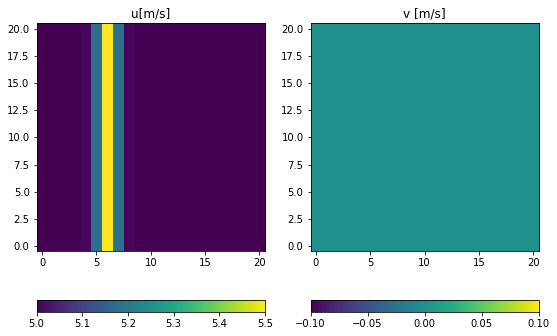

In [4]:
res_x=500
max_x=10000
x=np.arange(0,max_x+res_x,res_x)
res_y=500
max_y=10000
y = np.arange(0,max_y+res_y,res_y)
xm = np.outer(np.ones(len(y)),x)
ym = np.outer(np.ones(len(x)),y)
ym = np.transpose(ym)
u_mean=5.0
v_mean=0
du=0.5
dv=0
L=500
p0=3000

# input a simplified velocity field
u=np.zeros(xm.shape); u=u_mean+du*np.exp(-(xm-p0)**2/L**2)
v=np.zeros(u.shape); v=v_mean+dv*np.exp(-(ym-p0)**2/L**2)


plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(u,origin='lower')
plt.title('u[m/s]')
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(v,origin='lower')
plt.title('v [m/s]')
plt.colorbar(orientation='horizontal')


#plt.figure(figsize=(9,6))
#plt.subplot(1,2,1)
#plt.title('shear [1/s]')
#plt.imshow(dvdx)
#plt.colorbar(orientation='horizontal')
#plt.subplot(1,2,2)
#plt.imshow(dvdy)
#plt.colorbar(orientation='horizontal')

Spatially varying wave spectrum and backscatter

In [5]:
Tx_3D,Ty_3D=Kudry2005_wind1d( B_neq, B_eq, I_swpc, k_x, k_y, res_x, u_10, phi_w, fetch, m_star = 1 )

In [12]:
shp=k_x.shape
SHP=v.shape
dB=np.zeros((shp[0],shp[1],SHP[0],SHP[1]))
U=np.sqrt(u**2+v**2); U_mean=np.sqrt(u_mean**2+v_mean**2)
U = U * np.sqrt( (0.8 + 0.065 * U) * 1e-3 ) # convert to U_star
U_mean = U_mean * np.sqrt( (0.8 + 0.065 * U_mean) * 1e-3 ) # convert to U_star
for i in range(0,shp[0]):
    print(i)
    for j in range(0,shp[1]):
        #Tx_temp=np.reshape(Tx_4D[i,j,0,:],(1,SHP[1])) # convert it to 'one-dimensional' impulse response
        #Ty_temp=np.reshape(Ty_4D[i,j,:,0],(SHP[0],1))
        Tx_temp=np.reshape(Tx_3D[i,j,0:SHP[1]],(1,SHP[1])) # convert it to 'one-dimensional' impulse response
        Ty_temp=np.reshape(Ty_3D[i,j,0:SHP[0]],(SHP[0],1))
        dTx=sp.signal.convolve2d((U-U_mean)/U_mean,Tx_temp)[:,0:SHP[1]]
        dTy=sp.signal.convolve2d((U-U_mean)/U_mean,Ty_temp)[0:SHP[1],:]
        T=dTx[:,:]+dTy[:,:]
        if np.min(T) < -1:
            print('Warning! Negative values for curvature spectrum!')
            print(i,j,k_x[i,j],k_y[i,j],np.min(T))
        dB[i,j,:,:]=Bm[i,j]*T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [7]:
lambda_lim=6
k_lim=2*np.pi/lambda_lim
ph=np.linspace(0,2*np.pi,61)
xR=np.cos(ph)*k_lim
yR=np.sin(ph)*k_lim

In [11]:
sigma_sp=np.zeros(SHP) # specular scattering
sigma_br=np.zeros(SHP) # Bragg scattering
sigma_wb=np.zeros(SHP) # wave breaking
q=np.zeros(SHP) # fraction of surface covered by breakers
for i in range(0,SHP[0]):
    for j in range(0,SHP[1]):
        S=np.where(k > 0,(Bm+dB[:,:,i,j])*k**-4,Sm)
        S[S < 0]=0 # this is an override, which I do not like
        sigma_sp[i,j], sigma_br[i,j], sigma_wb[i,j], q[i,j] = backscatter.backscatter_Kudry2005( S, k_x, k_y, dks, phi_w, u_10=u_10)

plot

0.00034082769304031956 0.12043709315425666 0.01261697149243993 0.026228486459264774


Text(0.5, 1.0, 'total backscatter')

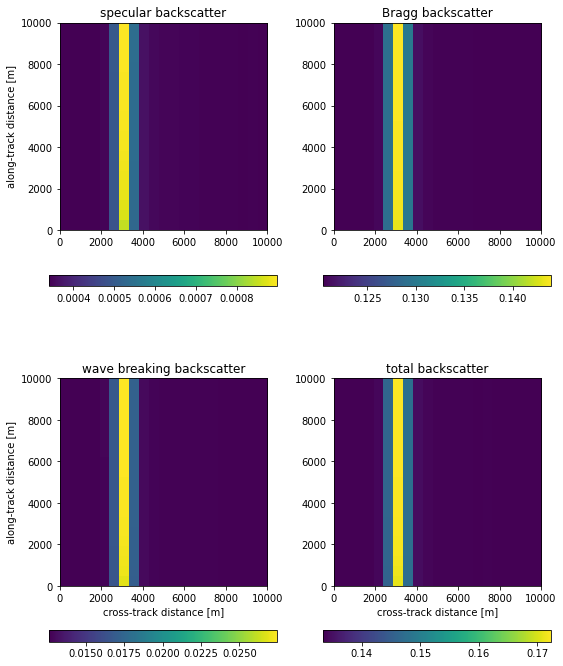

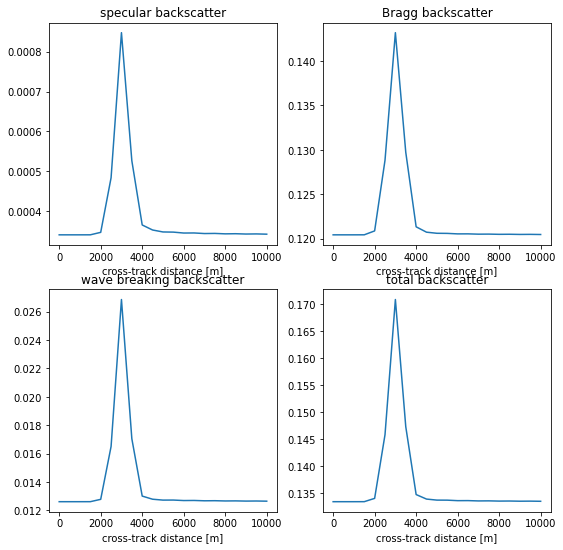

In [9]:
s_sp, s_br, s_wb, q_check = backscatter.backscatter_Kudry2005( Sm, k_x, k_y, dks, phi_w, u_10=u_10)
print(s_sp*(1-q_check),s_br*(1-q_check),s_wb*q_check,q_check)

plt.figure(figsize=(9,12))
plt.subplot(2,2,1)
plt.imshow(sigma_sp*(1-q),origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('specular backscatter')
#plt.xlabel('cross-track distance [m]')
plt.ylabel('along-track distance [m]')
plt.subplot(2,2,2)
plt.imshow(sigma_br*(1-q),origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('Bragg backscatter')
#plt.xlabel('cross-track distance [m]')
#plt.ylabel('along-track distance [m]')
plt.subplot(2,2,3)
plt.imshow(sigma_wb*q,origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('wave breaking backscatter')
plt.xlabel('cross-track distance [m]')
plt.ylabel('along-track distance [m]')
plt.subplot(2,2,4)
plt.imshow(sigma_sp*(1-q)+sigma_br*(1-q)+sigma_wb*q,origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('total backscatter')
plt.xlabel('cross-track distance [m]')
#plt.ylabel('along-track distance [m]')

plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.plot(x,sigma_sp[0,:]*(1-q[0,:]))
plt.xlabel('cross-track distance [m]')
plt.title('specular backscatter')
plt.subplot(2,2,2)
plt.plot(x,sigma_br[0,:]*(1-q[0,:]))
plt.xlabel('cross-track distance [m]')
plt.title('Bragg backscatter')
plt.subplot(2,2,3)
plt.plot(x,sigma_wb[0,:]*q[0,:])
plt.xlabel('cross-track distance [m]')
plt.title('wave breaking backscatter')
plt.subplot(2,2,4)
plt.plot(x,sigma_sp[0,:]*(1-q[0,:])+sigma_br[0,:]*(1-q[0,:])+sigma_wb[0,:]*q[0,:])
plt.xlabel('cross-track distance [m]')
plt.title('total backscatter')